# Ejemplo clasificación


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.4 MB/s eta 0:00:00


## Librerías

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 8

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
from joblib import Parallel, delayed, cpu_count

import optuna

# Configuración warnings
# ==============================================================================
import warnings


## Datos
El set de datos Carseats, original del paquete de R ISLR y accesible en Python a través de statsmodels.datasets.get_rdataset, contiene información sobre la venta de sillas infantiles en 400 tiendas distintas. Para cada una de las 400 tiendas se han registrado 11 variables. Se pretende generar un modelo de clasificación que permita predecir si una tienda tiene ventas altas (Sales > 8) o bajas (Sales <= 8) en función de todas las variables disponibles.

In [ ]:
# Lectura de datos
# ==============================================================================
dataframe = pd.read_csv(r"/content/BDSeleccionadaV3.csv")
dataframe.head(3)

,Edad,Sexo,IMC,CintCad,GrasCorp,Cigarrillos,Alcohol,Piel,Diabetes,MasaMusc,ActFisica,Trabajo,Farmacos,ProtectorSolar,ExposicionDias,ExposicionMinutos,VitaminaD
0,37,1,23.4,0.87,20.0,5,1,4,0,23.8,0,1,7,1,2,60,20.70
1,39,1,25.9,0.91,22.0,7,1,3,0,21.8,0,1,4,2,2,30,26.74
2,60,2,30.6,0.95,25.8,7,1,3,0,34.2,1,1,7,5,0,0,20.53


In [ ]:
# Actualizamos la función para categorizar los niveles de Vitamina D
def categorizar_vitamina_d_binario(valor):
    if valor < 20:
        return 0
    else:
        return 1

# Aplicamos la función actualizada a la columna de Vitamina D y creamos una nueva columna
dataframe['CategoriaVitaD'] = dataframe['VitaminaD'].apply(categorizar_vitamina_d_binario)

# Aseguramos que la columna 'CategoriaVitaD' sea de tipo entero
dataframe['CategoriaVitaD'] = dataframe['CategoriaVitaD'].astype(int)

print(dataframe.head())

   Edad  Sexo   IMC  CintCad  GrasCorp  Cigarrillos  Alcohol  Piel  Diabetes  \
0    37     1  23.4     0.87      20.0            5        1     4         0   
1    39     1  25.9     0.91      22.0            7        1     3         0   
2    60     2  30.6     0.95      25.8            7        1     3         0   
3    53     2  28.4     0.93      25.0            7        1     4         0   
4    39     2  25.2     0.89      18.8            7        1     3         0   

   MasaMusc  ActFisica  Trabajo  Farmacos  ProtectorSolar  ExposicionDias  \
0      23.8          0        1         7               1               2   
1      21.8          0        1         4               2               2   
2      34.2          1        1         7               5               0   
3      28.7          0        2         8               1               5   
4      26.8          1        1         8               2               1   

   ExposicionMinutos  VitaminaD  CategoriaVitaD  
0     

## Ajuste del modelo y optimización de hiperparámetros
Se ajusta un árbol de clasificación empleando como variable respuesta ventas_altas y como predictores todas las variables disponibles. Se utilizan en primer lugar los hiperparámetros max_depth=5 y criterion='gini', el resto se dejan por defecto. Después, se aplica el proceso de pruning y se comparan los resultados frente al modelo inicial.

In [ ]:
# División de los datos en train y test, excluyendo la columna 'VitaminaD'
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
    dataframe.drop(columns=['CategoriaVitaD', 'VitaminaD','ExposicionMinutos','ExposicionDias'	]),
    dataframe['CategoriaVitaD'],
    random_state=123
)

# One-hot-encoding de las variables categóricas
# ==============================================================================
# Se identifica el nombre de las columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
    [('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary'), cat_cols)],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")

# Aplicación de las transformaciones a los conjuntos de entrenamiento y prueba
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)


In [ ]:
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 805 entries, 66 to 1041
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Edad            805 non-null    int64  
 1   Sexo            805 non-null    int64  
 2   IMC             805 non-null    float64
 3   CintCad         805 non-null    float64
 4   GrasCorp        805 non-null    float64
 5   Cigarrillos     805 non-null    int64  
 6   Alcohol         805 non-null    int64  
 7   Piel            805 non-null    int64  
 8   Diabetes        805 non-null    int64  
 9   MasaMusc        805 non-null    float64
 10  ActFisica       805 non-null    int64  
 11  Trabajo         805 non-null    int64  
 12  Farmacos        805 non-null    int64  
 13  ProtectorSolar  805 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 94.3 KB


## Grid Search basado en out-of-bag score

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )


# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:

    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )

    modelo.fit(X_train_prep, y_train)

    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns='params')
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterio

,oob_accuracy,criterion,max_depth,max_features,n_estimators
16,0.698137,entropy,3.0,7,150
3,0.695652,gini,3.0,5,150
5,0.695652,gini,3.0,9,150
6,0.695652,gini,10.0,5,150


In [ ]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-accuracy)")
print("--------------------------------------------------")
print(resultados.iloc[0,0:])

--------------------------------------------------
Mejores hiperparámetros encontrados (oob-accuracy)
--------------------------------------------------
oob_accuracy    0.698137
criterion        entropy
max_depth            3.0
max_features           7
n_estimators         150
Name: 16, dtype: object


## Grid Search basado en validación cruzada

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {
    'n_estimators': [150],
    'max_features': [5, 7, 9],
    'max_depth'   : [None, 3, 10, 20],
    'criterion'   : ['gini', 'entropy']
}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123),
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X=X_train_prep, y=y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex='(param*|mean_t|std_t)') \
    .drop(columns='params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_criterion,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
5,gini,3,9,150,0.693168,0.028218,0.733126,0.010188
17,entropy,3,9,150,0.693168,0.029027,0.728364,0.009613
16,entropy,3,7,150,0.689855,0.023837,0.726812,0.010213
4,gini,3,7,150,0.689855,0.026397,0.731056,0.010427


In [ ]:
# Mejores hiperparámetros encontrados por validación cruzada
# ==============================================================================
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados por (cv)")
print("--------------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

--------------------------------------------
Mejores hiperparámetros encontrados por (cv)
--------------------------------------------
{'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'n_estimators': 150} : 0.6931677018633541 accuracy


## Predicción y evaluación del modelo

In [ ]:
# Modelo con los mejores hiperparámetros
# ==============================================================================
modelo_final = grid.best_estimator_
modelo_final

RandomForestClassifier(max_depth=3, max_features=9, n_estimators=150,
                       random_state=123)

In [ ]:
# Error de test del modelo final
# ==============================================================================
predicciones = modelo_final.predict(X=X_test_prep)
predicciones[:50]

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1])

Matriz de confusión
-------------------
[[ 56  41]
 [ 32 140]]

El accuracy de test es: 72.86245353159852 % 

              precision    recall  f1-score   support

           0       0.64      0.58      0.61        97
           1       0.77      0.81      0.79       172

    accuracy                           0.73       269
   macro avg       0.70      0.70      0.70       269
weighted avg       0.72      0.73      0.73       269



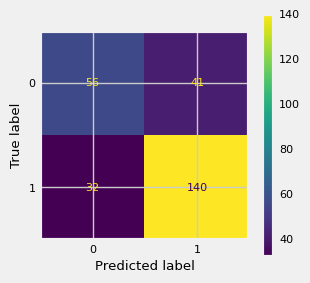

In [ ]:
mat_confusion = confusion_matrix(y_true=y_test, y_pred=predicciones)
accuracy = accuracy_score(y_true=y_test, y_pred=predicciones, normalize=True)
print("Matriz de confusión")
print("-------------------")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} % \n")
fig, ax = plt.subplots(figsize=(3, 3))
ConfusionMatrixDisplay(mat_confusion).plot(ax=ax)

print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)

## Predicción de probabilidades
 Con .predict_proba(), en lugar de una clasificación, se obtiene la probabilidad con la que el modelo considera que cada observación puede pertenecer a cada una de las clases.

In [ ]:
# Predicción de probabilidades
# ==============================================================================
predicciones = modelo_final.predict_proba(X=X_test_prep)
predicciones[:5, :]

array([[0.36293825, 0.63706175],
       [0.6595062 , 0.3404938 ],
       [0.2463196 , 0.7536804 ],
       [0.21109008, 0.78890992],
       [0.40592846, 0.59407154]])

In [ ]:
# Clasificación empleando la clase de mayor probabilidad
# ==============================================================================
df_predicciones = pd.DataFrame(data=predicciones, columns=['Suficiencia', 'Insuficiencia'])

df_predicciones['Clasificacion'] = df_predicciones.idxmax(axis=1)

print(df_predicciones.head())

   Suficiencia  Insuficiencia  Clasificacion
0     0.362938       0.637062  Insuficiencia
1     0.659506       0.340494    Suficiencia
2     0.246320       0.753680  Insuficiencia
3     0.211090       0.788910  Insuficiencia
4     0.405928       0.594072  Insuficiencia


In [ ]:
df_predicciones['clasificacion_custom_0.8'] = np.where(df_predicciones['Insuficiencia'] > 0.8, 1, 0)

print(df_predicciones.iloc[4:10, :])

   Suficiencia  Insuficiencia  Clasificacion  clasificacion_custom_0.8
4     0.405928       0.594072  Insuficiencia                         0
5     0.197905       0.802095  Insuficiencia                         1
6     0.576518       0.423482    Suficiencia                         0
7     0.288747       0.711253  Insuficiencia                         0
8     0.256557       0.743443  Insuficiencia                         0
9     0.677891       0.322109    Suficiencia                         0


# Importancia de predictores
## Importancia por pureza de nodos

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X_train_prep.columns,
                             'importancia': modelo_final.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
9,MasaMusc,0.449491
0,Edad,0.142856
6,Alcohol,0.130524
12,Farmacos,0.047691
4,GrasCorp,0.043176
2,IMC,0.037406
3,CintCad,0.036157
11,Trabajo,0.030584
7,Piel,0.030095
1,Sexo,0.024851


##Importancia por permutación

In [ ]:
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train_prep,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = cpu_count() - 1,
                random_state = 123,
             )

df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train_prep.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
9,0.066430,0.013913,MasaMusc
0,0.030704,0.005296,Edad
4,0.006565,0.001584,GrasCorp
2,0.002824,0.000940,IMC
3,0.001649,0.000940,CintCad
1,0.001636,0.003842,Sexo
13,0.000707,0.000577,ProtectorSolar
10,0.000472,0.000577,ActFisica
8,0.000000,0.000000,Diabetes
7,-0.000003,0.001669,Piel


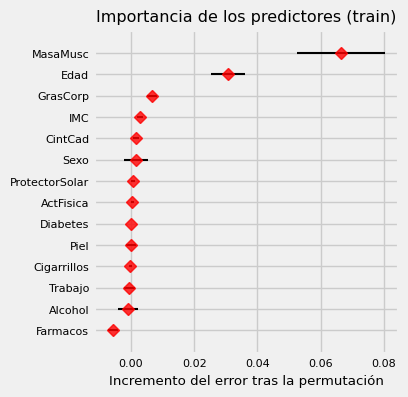

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(3.5, 4))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

In [ ]:
import joblib

joblib.dump(modelo_final, '/content/RF_model.joblib')

['/content/RF_model.joblib']